<a href="https://colab.research.google.com/github/flohmannjr/tensorflow_curso/blob/main/TensorFlow_NLP_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Natural Language Processing

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random, time

from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import clone_model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Embedding, TextVectorization
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, GlobalMaxPool1D, Input
from tensorflow.keras.layers import Bidirectional, Conv1D, GRU, LSTM

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

## Setup

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-darkgrid')

### Constantes

In [3]:
SEMENTE = 2008193

ENTRADA_FORMATO = (1,)
ENTRADA_TIPO = tf.string

ATIVACAO_CNN = 'relu'
ATIVACAO_RNN = 'tanh'
ATIVACAO_SAIDA = 'sigmoid'

FILTROS = 32
NUCLEO_TAMANHO = 32
PREENCHIMENTO = 'same'

PERDA = 'binary_crossentropy'
APRENDIZADO = 0.001
METRICAS = ['accuracy']

ITERACOES = 5

DIRETORIO_TB = 'tb_nlp'

### Funções

In [4]:
!wget https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py

--2023-01-29 06:34:03--  https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5196 (5.1K) [text/plain]
Saving to: ‘funcoes.py’

funcoes.py          100%[===================>]   5.07K  --.-KB/s    in 0s      

2023-01-29 06:34:03 (61.0 MB/s) - ‘funcoes.py’ saved [5196/5196]



In [5]:
from funcoes import criar_callback_tensorboard, grafico_historico_por_iteracao, unzip_data

In [6]:
def avaliar_modelo(previsao, validacao):
    print(classification_report(validacao, previsao))

    ConfusionMatrixDisplay.from_predictions(validacao, previsao, cmap='summer_r')
    plt.grid(False)

    relatorio = classification_report(validacao, previsao, output_dict=True)

    return {'acuracia': relatorio['accuracy'],
            'precisao': relatorio['weighted avg']['precision'],
            'revocacao': relatorio['weighted avg']['recall'],
            'pontuacao-f1': relatorio['weighted avg']['f1-score']}

### Limpar diretorio TensorBoard

In [7]:
# # Apagar diretórios não-vazios
# import shutil
# shutil.rmtree(DIRETORIO_TB)

## Dados

Dados originalmente da competição **Natural Language Processing with Disaster Tweets** no Kaggle. (Em andamento em 27.01.2023.)

https://www.kaggle.com/c/nlp-getting-started

In [8]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

unzip_data('nlp_getting_started.zip')

--2023-01-29 06:34:03--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K   755KB/s    in 0.8s    

2023-01-29 06:34:04 (755 KB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [9]:
df_treino = pd.read_csv('train.csv')
df_teste = pd.read_csv('test.csv')

# Embaralhar dados de treino (frac=1 = 100% dos dados)
df_treino = df_treino.sample(frac=1, random_state=SEMENTE)

In [10]:
df_treino.head()

,id,keyword,location,text,target
2299,3299,demolish,NYHC,If you think going to demolish Drake's house o...,1
3704,5269,fear,Carregado,I didn`t want to hurt you but the fear drove m...,0
3468,4961,explosion,New York,New Explosion-proof Tempered Glass Screen Prot...,0
6653,9533,terrorist,????? ???? ????,#UdhampurAgain 2 terrorist shot dead.. #Udhampur,1
3634,5183,fatalities,jersey,mortal kombat fatalities are so gross but inte...,0


In [11]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 2299 to 4895
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 356.9+ KB


In [12]:
df_treino['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

### Separar dados para validação

In [13]:
X = df_treino['text']
y = df_treino['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEMENTE)

## Converter texto em números

In [14]:
limite_dicionario = 10000

media_palavras_por_texto = round(sum([len(texto.split()) for texto in X_train]) / len(X_train))
# maximo_palavras_por_texto = max([len(texto.split()) for texto in X_train])

tamanho_texto = media_palavras_por_texto

### Vetorização (Vectorization)

In [15]:
vetorizador = TextVectorization(max_tokens=limite_dicionario,               # (Default: None) Máximo de tokens (palavras) no dicionário.
                                standardize='lower_and_strip_punctuation',  # (Default) Texto em caixa baixa e retira caracteres especiais.
                                split='whitespace',                         # (Default) Separador de tokens.
                                ngrams=None,                                # (Default) Tokens por grupo. (None = não agrupar tokens.)
                                output_mode='int',                          # (Default) Como mapear tokens para números.
                                output_sequence_length=tamanho_texto)       # (Default: None) Tamanho do texto, completado ou truncado, se necessário. (Válido apenas para 'int'.)

In [16]:
vetorizador.adapt(X_train)

In [17]:
texto = random.choice(X_train)
print(texto)

vetorizador([texto])

Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires' disea... http://t.co/oJyW7jkUH5


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[139,   5, 642,  64, 194,  53,  79, 479, 139, 551,  18,   2, 188,
        341,   6]])>

In [18]:
vocabulario = vetorizador.get_vocabulary()

In [19]:
# [UNK] = Desconhecido, fora do limite do dicionário.
len(vocabulario), vocabulario[:5], vocabulario[-5:]

(10000,
 ['', '[UNK]', 'the', 'a', 'in'],
 ['pacic', 'p45perez', 'oyster', 'oworoshoki', 'ownership'])

### Incorporação (Embedding)

In [20]:
incorporador = Embedding(input_dim=limite_dicionario,  # Tamanho do vocabulário de entrada.
                         output_dim=128,               # Dimensão do vetor de saída. (Geralmente um múltiplo de 8.)
                         input_length=tamanho_texto)   # Tamanho do texto de entrada.

In [21]:
texto = random.choice(X_train)
print(texto)

incorporador(vetorizador([texto]))

AMBULANCE SPRINTER AUTOMATIC FRONTLINE VEHICLE CHOICE OF 14 LEZ COMPLIANT | eBay http://t.co/UJrX9kgawp


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.04995641,  0.0310593 ,  0.00490378, ..., -0.04975635,
          0.02047822,  0.04372041],
        [ 0.02290884,  0.00253878, -0.01452812, ...,  0.01112006,
         -0.00786034, -0.02538692],
        [ 0.00300956,  0.00833621,  0.04256078, ..., -0.01495417,
         -0.03281917, -0.02854469],
        ...,
        [ 0.00470575, -0.04538809, -0.04056036, ..., -0.01854389,
         -0.01388413,  0.041064  ],
        [ 0.00470575, -0.04538809, -0.04056036, ..., -0.01854389,
         -0.01388413,  0.041064  ],
        [ 0.00470575, -0.04538809, -0.04056036, ..., -0.01854389,
         -0.01388413,  0.041064  ]]], dtype=float32)>

## Experimentos

* Model 0: Naive Bayes with TF-IDF encoder (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional LSTM (RNN)
* Model 5: 1D Convolutional Neural Network
* Model 6: TFHub Universal Sentence Encoder
* Model 7: Same as model 6 but using 10% of data

In [22]:
modelos = [None] * 8
avaliacoes = [None] * 8
previsoes = [None] * 8
relatorios = [None] * 8

probabilidades = [None] * 8
historicos = [None] * 8

In [23]:
def dados_modelo(indice):
    avaliacoes[indice] = modelos[indice].evaluate(X_test, y_test)
    probabilidades[indice] = modelos[indice].predict(X_test)
    previsoes[indice] = tf.squeeze(tf.round(probabilidades[indice]))
    relatorios[indice] = avaliar_modelo(previsoes[indice], y_test)

### Modelo 0: Naive Bayes with TF-IDF encoder (baseline)

In [24]:
modelos[0] = Pipeline([('tdidf', TfidfVectorizer()),
                       ('clf', MultinomialNB())]) # clf = classifier

modelos[0].fit(X_train, y_train)

Pipeline(steps=[('tdidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
avaliacoes[0] = modelos[0].score(X_test, y_test)
avaliacoes[0]

0.8083989501312336

In [26]:
previsoes[0] = modelos[0].predict(X_test)
previsoes[0][:20]

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1])

              precision    recall  f1-score   support

           0       0.77      0.94      0.85       433
           1       0.88      0.64      0.74       329

    accuracy                           0.81       762
   macro avg       0.83      0.79      0.80       762
weighted avg       0.82      0.81      0.80       762



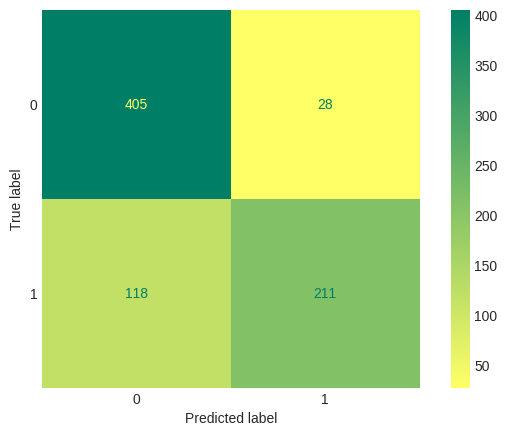

In [27]:
relatorios[0] = avaliar_modelo(previsoes[0], y_test)

In [28]:
relatorios[0]

{'acuracia': 0.8083989501312336,
 'precisao': 0.821209966257038,
 'revocacao': 0.8083989501312336,
 'pontuacao-f1': 0.8022381673606139}

### Modelo 1: Feed-forward neural network (dense model)

In [29]:
modelo_nome = 'modelo_1_dense'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas = vetorizador(entradas)
camadas = incorporador(camadas)
camadas = GlobalAveragePooling1D(name='agrupamento_media_global')(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[1] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[1].compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

historicos[1] = modelos[1].fit(x=X_train,
                               y=y_train,
                               epochs=ITERACOES,
                               validation_data=(X_test, y_test),
                               # callbacks=[criar_callback_tensorboard(diretorio=DIRETORIO_TB, experimento=modelo_nome)],
                               verbose=1)

Epoch 1/5
215/215 [==============================] - 6s 9ms/step - loss: 0.6127 - accuracy: 0.6868 - val_loss: 0.5167 - val_accuracy: 0.7900
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.4438 - accuracy: 0.8186 - val_loss: 0.4395 - val_accuracy: 0.8097
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3503 - accuracy: 0.8603 - val_loss: 0.4180 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2883 - accuracy: 0.8888 - val_loss: 0.4176 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2408 - accuracy: 0.9096 - val_loss: 0.4273 - val_accuracy: 0.8058


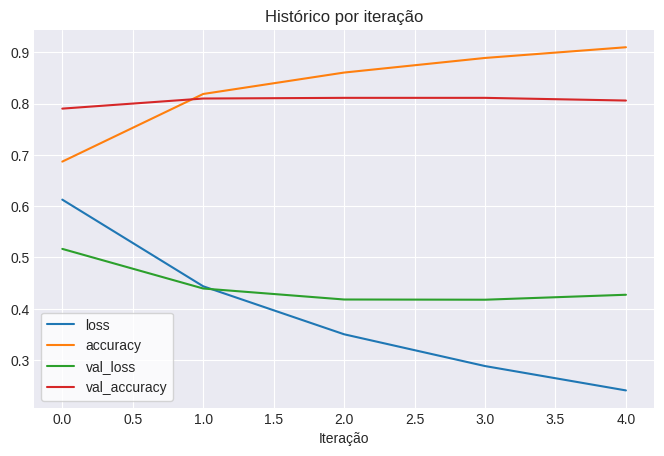

In [30]:
grafico_historico_por_iteracao(historicos[1])

24/24 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       433
           1       0.80      0.73      0.77       329

    accuracy                           0.81       762
   macro avg       0.80      0.80      0.80       762
weighted avg       0.81      0.81      0.80       762



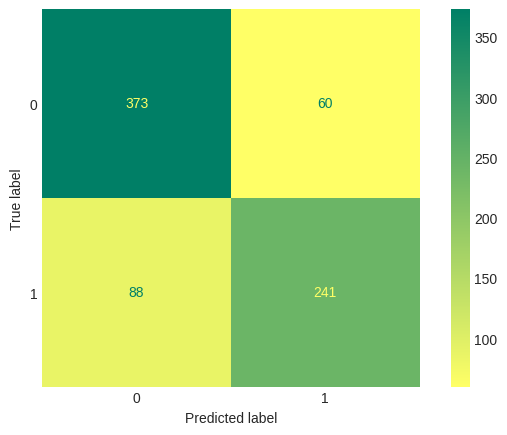

In [31]:
dados_modelo(1)

In [32]:
relatorios[1]

{'acuracia': 0.8057742782152231,
 'precisao': 0.8054639199964303,
 'revocacao': 0.8057742782152231,
 'pontuacao-f1': 0.804499717177411}

### Modelo 2: LSTM model (RNN)

In [33]:
modelo_nome = 'modelo_2_lstm'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas = vetorizador(entradas)
camadas = incorporador(camadas)

# camadas = LSTM(units=64, activation=ATIVACAO_RNN, return_sequences=True)(camadas) # Para empilhar camadas recorrentes é necessário return_sequences=True
camadas = LSTM(units=64, activation=ATIVACAO_RNN)(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[2] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[2].compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

historicos[2] = modelos[2].fit(x=X_train,
                               y=y_train,
                               epochs=ITERACOES,
                               validation_data=(X_test, y_test),
                               # callbacks=[criar_callback_tensorboard(diretorio=DIRETORIO_TB, experimento=modelo_nome)],
                               verbose=1)

Epoch 1/5
215/215 [==============================] - 6s 9ms/step - loss: 0.2284 - accuracy: 0.9155 - val_loss: 0.5011 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1574 - accuracy: 0.9423 - val_loss: 0.4823 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1304 - accuracy: 0.9531 - val_loss: 0.6270 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1087 - accuracy: 0.9593 - val_loss: 0.6558 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0921 - accuracy: 0.9639 - val_loss: 0.7150 - val_accuracy: 0.7756


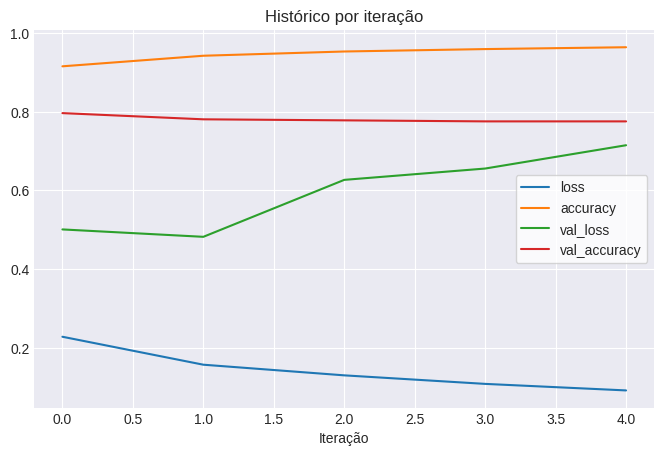

In [34]:
grafico_historico_por_iteracao(historicos[2])

24/24 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       433
           1       0.78      0.67      0.72       329

    accuracy                           0.78       762
   macro avg       0.78      0.76      0.77       762
weighted avg       0.78      0.78      0.77       762



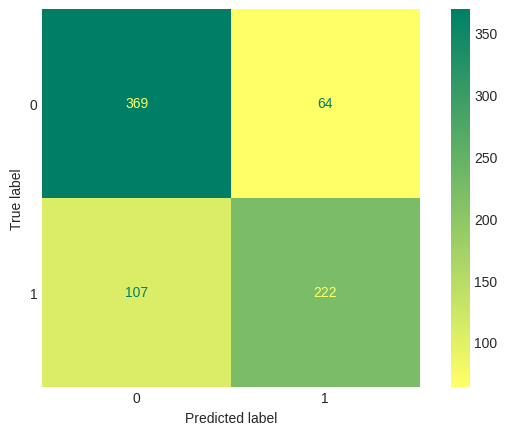

In [35]:
dados_modelo(2)

In [36]:
relatorios[2]

{'acuracia': 0.7755905511811023,
 'precisao': 0.7756477542836968,
 'revocacao': 0.7755905511811023,
 'pontuacao-f1': 0.7730531570537502}

### Modelo 3: GRU model (RNN)

In [37]:
modelo_nome = 'modelo_3_gru'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas = vetorizador(entradas)
camadas = incorporador(camadas)

# camadas = GRU(units=64, activation=ATIVACAO_RNN, return_sequences=True)(camadas)
camadas = GRU(units=64, activation=ATIVACAO_RNN)(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camda_saida')(camadas)

modelos[3] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[3].compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

historicos[3] = modelos[3].fit(x=X_train,
                               y=y_train,
                               epochs=ITERACOES,
                               validation_data=(X_test, y_test),
                               # callbacks=[criar_callback_tensorboard(diretorio=DIRETORIO_TB, experimento=modelo_nome)],
                               verbose=1)

Epoch 1/5
215/215 [==============================] - 3s 8ms/step - loss: 0.1505 - accuracy: 0.9438 - val_loss: 0.7079 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0827 - accuracy: 0.9696 - val_loss: 0.7864 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0729 - accuracy: 0.9737 - val_loss: 0.9540 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0698 - accuracy: 0.9717 - val_loss: 0.8701 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0608 - accuracy: 0.9756 - val_loss: 0.9069 - val_accuracy: 0.7756


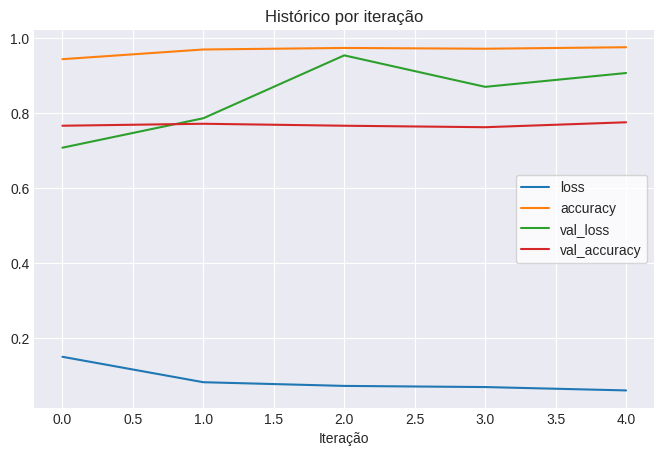

In [38]:
grafico_historico_por_iteracao(historicos[3])

24/24 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       433
           1       0.74      0.74      0.74       329

    accuracy                           0.78       762
   macro avg       0.77      0.77      0.77       762
weighted avg       0.78      0.78      0.78       762



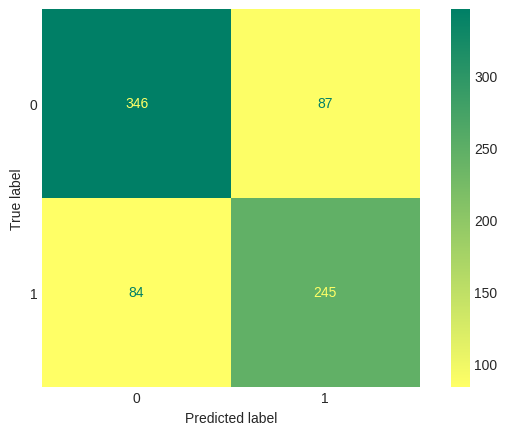

In [39]:
dados_modelo(3)

In [40]:
relatorios[3]

{'acuracia': 0.7755905511811023,
 'precisao': 0.7758531470691409,
 'revocacao': 0.7755905511811023,
 'pontuacao-f1': 0.7757097498792934}

### Modelo 4: Bidirectional LSTM (RNN)

In [41]:
modelo_nome = 'modelo_4_bidirectional_lstm'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas = vetorizador(entradas)
camadas = incorporador(camadas)

# camadas = Bidirectional(layer=LSTM(units=64, activation=ATIVACAO_RNN, return_sequences=True))(camadas)
camadas = Bidirectional(layer=LSTM(units=64, activation=ATIVACAO_RNN))(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[4] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[4].compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

historicos[4] = modelos[4].fit(x=X_train,
                               y=y_train,
                               epochs=ITERACOES,
                               validation_data=(X_test, y_test),
                               # callbacks=[criar_callback_tensorboard(diretorio=DIRETORIO_TB, experimento=modelo_nome)],
                               verbose=1)

Epoch 1/5
215/215 [==============================] - 5s 11ms/step - loss: 0.1052 - accuracy: 0.9682 - val_loss: 0.8614 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0587 - accuracy: 0.9783 - val_loss: 0.9545 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0511 - accuracy: 0.9764 - val_loss: 1.2454 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0444 - accuracy: 0.9797 - val_loss: 1.1613 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0457 - accuracy: 0.9769 - val_loss: 1.2013 - val_accuracy: 0.7625


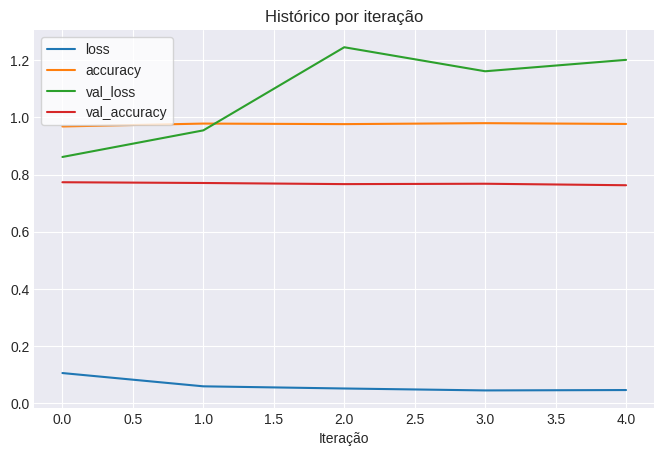

In [42]:
grafico_historico_por_iteracao(historicos[4])

24/24 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.80      0.77      0.79       433
           1       0.72      0.75      0.73       329

    accuracy                           0.76       762
   macro avg       0.76      0.76      0.76       762
weighted avg       0.76      0.76      0.76       762



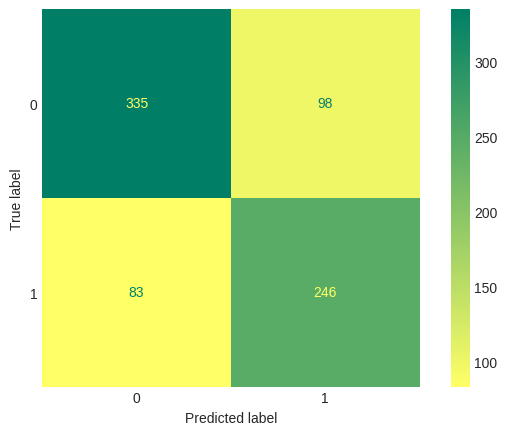

In [43]:
dados_modelo(4)

In [44]:
relatorios[4]

{'acuracia': 0.7624671916010499,
 'precisao': 0.7641663870268136,
 'revocacao': 0.7624671916010499,
 'pontuacao-f1': 0.7630208733969838}

### Modelo 5: 1D Convolutional Neural Network

In [45]:
modelo_nome = 'modelo_5_1d_cnn'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas = vetorizador(entradas)
camadas = incorporador(camadas)

camadas = Conv1D(filters=FILTROS,
                 kernel_size=NUCLEO_TAMANHO,  # Quantidade de palavras processadas por vez.
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_convulacional')(camadas)

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[5] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[5].compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

historicos[5] = modelos[5].fit(x=X_train,
                               y=y_train,
                               epochs=ITERACOES,
                               validation_data=(X_test, y_test),
                               # callbacks=[criar_callback_tensorboard(diretorio=DIRETORIO_TB, experimento=modelo_nome)],
                               verbose=1)

Epoch 1/5
215/215 [==============================] - 5s 6ms/step - loss: 0.0961 - accuracy: 0.9740 - val_loss: 0.9555 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0605 - accuracy: 0.9764 - val_loss: 1.0309 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0548 - accuracy: 0.9764 - val_loss: 1.0987 - val_accuracy: 0.7585
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0461 - accuracy: 0.9799 - val_loss: 1.1728 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0451 - accuracy: 0.9793 - val_loss: 1.2369 - val_accuracy: 0.7664


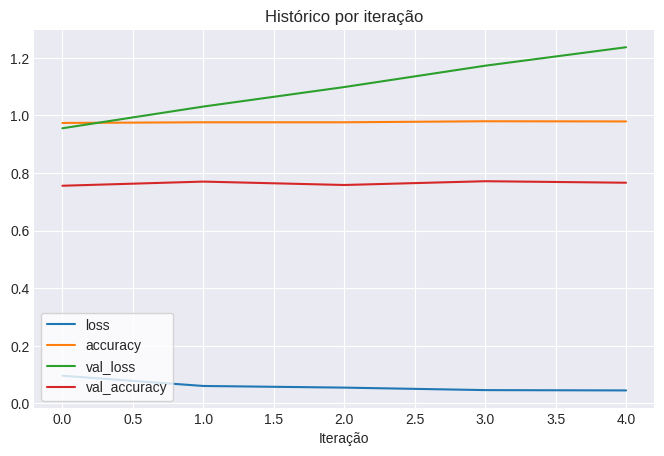

In [46]:
grafico_historico_por_iteracao(historicos[5])

24/24 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.79      0.80      0.79       433
           1       0.73      0.73      0.73       329

    accuracy                           0.77       762
   macro avg       0.76      0.76      0.76       762
weighted avg       0.77      0.77      0.77       762



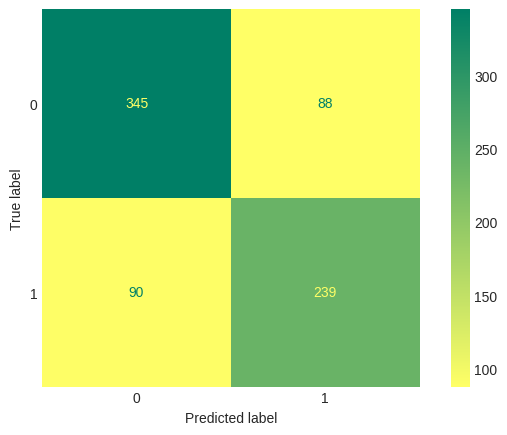

In [47]:
dados_modelo(5)

In [48]:
relatorios[5]

{'acuracia': 0.7664041994750657,
 'precisao': 0.7662409013172626,
 'revocacao': 0.7664041994750657,
 'pontuacao-f1': 0.766317227901587}

### Modelo 6: TFHub Universal Sentence Encoder

Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

In [49]:
modelo_nome = 'modelo_6_tfhub_use'

modelos[6] = Sequential(name=modelo_nome)

modelos[6].add(hub.KerasLayer(handle='https://tfhub.dev/google/universal-sentence-encoder/4',
                              trainable=False,
                              input_shape=[], # USE aceita textos de tamanho variável.
                              dtype=ENTRADA_TIPO,
                              name='camada_use'))

modelos[6].add(Dense(64, activation=ATIVACAO_CNN, name='camada_relu'))
modelos[6].add(Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida'))

modelos[6].compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

historicos[6] = modelos[6].fit(x=X_train,
                               y=y_train,
                               epochs=ITERACOES,
                               validation_data=(X_test, y_test),
                               # callbacks=[criar_callback_tensorboard(diretorio=DIRETORIO_TB, experimento=modelo_nome)],
                               verbose=1)

Epoch 1/5
215/215 [==============================] - 7s 13ms/step - loss: 0.5033 - accuracy: 0.7824 - val_loss: 0.4473 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4133 - accuracy: 0.8165 - val_loss: 0.4320 - val_accuracy: 0.7992
Epoch 3/5
215/215 [==============================] - 2s 12ms/step - loss: 0.4001 - accuracy: 0.8241 - val_loss: 0.4294 - val_accuracy: 0.7940
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3911 - accuracy: 0.8298 - val_loss: 0.4286 - val_accuracy: 0.7966
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3849 - accuracy: 0.8326 - val_loss: 0.4252 - val_accuracy: 0.8045


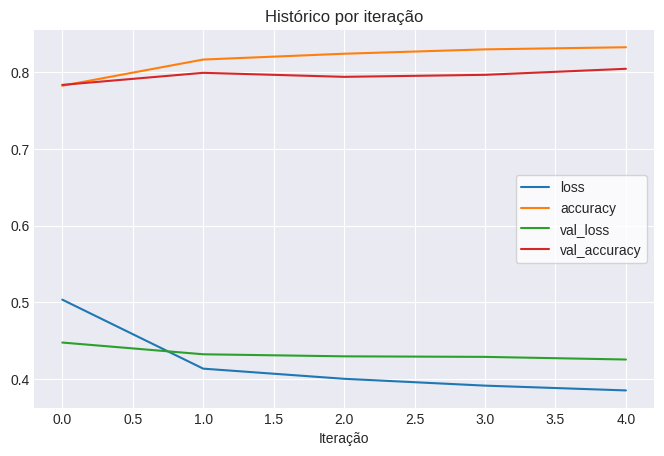

In [50]:
grafico_historico_por_iteracao(historicos[6])

24/24 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       433
           1       0.81      0.71      0.76       329

    accuracy                           0.80       762
   macro avg       0.81      0.79      0.80       762
weighted avg       0.81      0.80      0.80       762



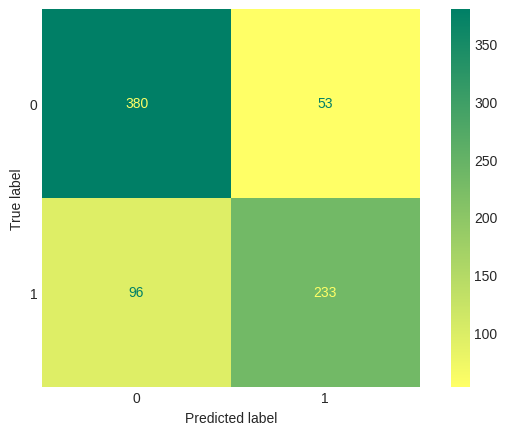

In [51]:
dados_modelo(6)

In [52]:
relatorios[6]

{'acuracia': 0.8044619422572179,
 'precisao': 0.8053854822034535,
 'revocacao': 0.8044619422572179,
 'pontuacao-f1': 0.8022509964971275}

### Modelo 7: Same as model 6 but using 10% of data

#### Separar 10% dos dados

In [53]:
X_train_10 = X_train.sample(frac=0.1, random_state=SEMENTE)
y_train_10 = y_train.sample(frac=0.1, random_state=SEMENTE)

#### Clonar Modelo 6

In [54]:
modelo_nome = 'modelo_7_tfhub_use_10'

modelos[7] = clone_model(modelos[6])
modelos[7]._name = modelo_nome

modelos[7].compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

historicos[7] = modelos[7].fit(x=X_train_10,
                               y=y_train_10,
                               epochs=ITERACOES,
                               validation_data=(X_test, y_test),
                               # callbacks=[criar_callback_tensorboard(diretorio=DIRETORIO_TB, experimento=modelo_nome)],
                               verbose=1)

Epoch 1/5
22/22 [==============================] - 3s 37ms/step - loss: 0.6694 - accuracy: 0.6993 - val_loss: 0.6448 - val_accuracy: 0.7625
Epoch 2/5
22/22 [==============================] - 0s 21ms/step - loss: 0.5919 - accuracy: 0.8146 - val_loss: 0.5816 - val_accuracy: 0.7756
Epoch 3/5
22/22 [==============================] - 0s 22ms/step - loss: 0.5073 - accuracy: 0.8321 - val_loss: 0.5268 - val_accuracy: 0.7822
Epoch 4/5
22/22 [==============================] - 0s 21ms/step - loss: 0.4414 - accuracy: 0.8321 - val_loss: 0.4990 - val_accuracy: 0.7861
Epoch 5/5
22/22 [==============================] - 0s 21ms/step - loss: 0.3985 - accuracy: 0.8453 - val_loss: 0.4830 - val_accuracy: 0.7808


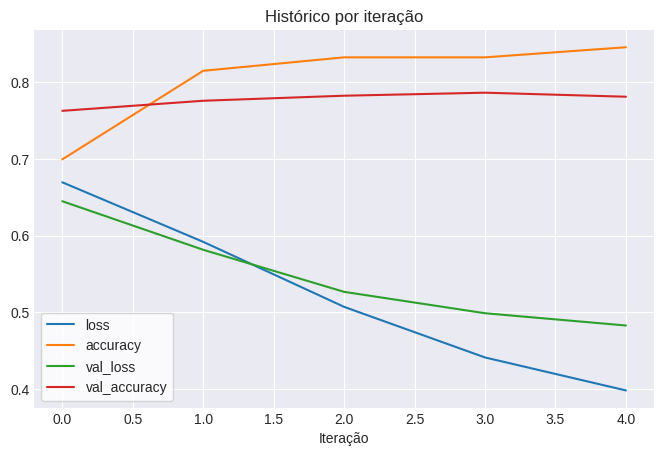

In [55]:
grafico_historico_por_iteracao(historicos[7])

24/24 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       433
           1       0.75      0.73      0.74       329

    accuracy                           0.78       762
   macro avg       0.78      0.77      0.78       762
weighted avg       0.78      0.78      0.78       762



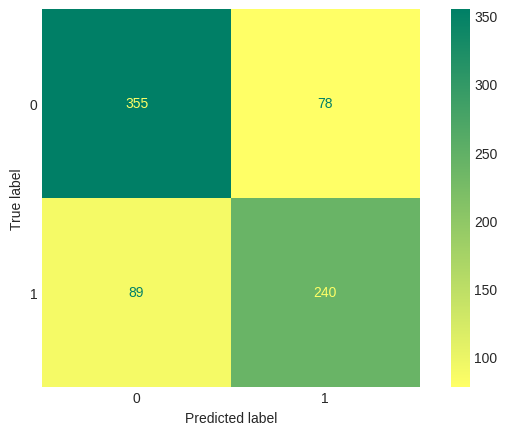

In [56]:
dados_modelo(7)

In [57]:
relatorios[7]

{'acuracia': 0.7808398950131233,
 'precisao': 0.7801927057052597,
 'revocacao': 0.7808398950131233,
 'pontuacao-f1': 0.7803513009885871}

## Comparar modelos

In [58]:
comparacao = pd.DataFrame(relatorios)
comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

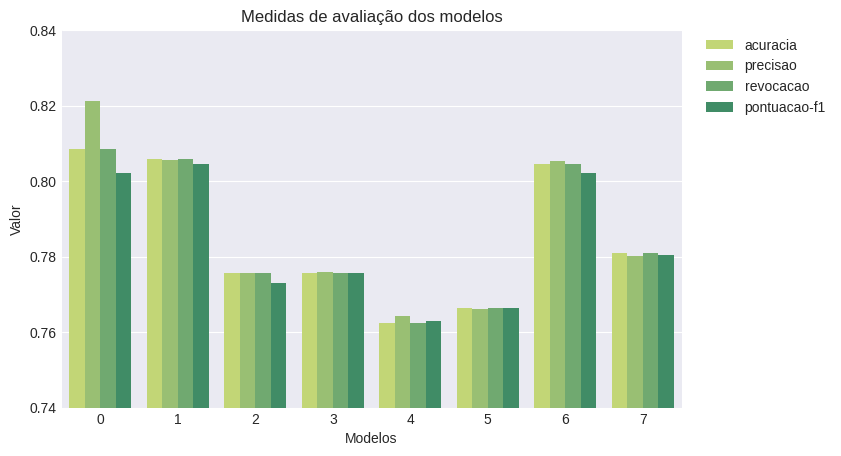

In [59]:
sns.barplot(data=comparacao, x='Index', y='Value', hue='Variable', palette='summer_r')

plt.ylim(0.74, 0.84)

plt.title('Medidas de avaliação dos modelos')
plt.xlabel('Modelos')
plt.ylabel('Valor')

plt.legend(loc=(1.03, 0.76));

### TensorBoard

In [60]:
# !tensorboard dev upload --logdir ./$DIRETORIO_TB/ \
#                         --name "Modelos PLN" \
#                         --description "Testes de modelos Naive Bayes, Dense, LSTM, GRU, Bidirectional LSTM, Conv1D e USE para PLN. Base de dados nlp-getting-started (Kaggle)." \
#                         --one_shot

TensorBoard link: https://tensorboard.dev/experiment/t962Gl86T4mSJ7JlM1GYrQ/

## Encontrar os exemplos "mais errados"

In [61]:
pd.set_option('display.max_colwidth', None)

pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 20)

for indice in range(1, 8):
    df = pd.DataFrame({'text': X_test,
                       'target': y_test,
                       'previsão': previsoes[indice],
                       'probabilidade': tf.squeeze(probabilidades[indice])})

    mais_errados = df[df["target"] != df["previsão"]].sort_values("probabilidade", ascending=False)
    
    print()
    print('=' * 8)
    print(f"Modelo {indice}")
    print('=' * 8)
    
    display(mais_errados)


Modelo 1


,text,target,previsão,probabilidade
4476,#hot C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/zY3hpdJNwg #prebreak #best,0,1.0,0.990228
4227,09:13 PM: Hazardous Weather Outlook (http://t.co/ed1VpITsWY): NO HAZARDOUS WEATHER IS EXPECTED AT THIS TIME.... http://t.co/6XSbddlZiy,0,1.0,0.976455
3806,Former Township fire truck being used in Philippines - Langley Times http://t.co/iMiLsFxntf #filipino,0,1.0,0.963693
7249,@Glosblue66 no idea what this means. Look at our violent crime rate without weapons. Ban guns we become like Mexico not Australia,0,1.0,0.878004
7043,Satellite Spies Super Typhoon Soudelor from Space (Photo) http://t.co/VBhu2t8wgB,0,1.0,0.860133
2121,53 years ago this week is the anniversary of Marilyn Monroe's death RIPRIPRIP,0,1.0,0.821708
2037,Don't like those head first slides. Especially into home !! #danger,0,1.0,0.800499
2131,Breast milk is the original #superfood but rates worldwide have stalled below 40% contributing to more than 800000 child deaths last year.,0,1.0,0.794804
5152,The People's Republic Of China ( PROC ): Abandon the West Philippine Sea and all the ... https://t.co/pD14GsrfSC via @ChangePilipinas,0,1.0,0.792055
7107,@Skarletan åÇ the storm. A violent swell of emotions then nothing.,0,1.0,0.789286



Modelo 2


,text,target,previsão,probabilidade
4476,#hot C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/zY3hpdJNwg #prebreak #best,0,1.0,0.999692
3806,Former Township fire truck being used in Philippines - Langley Times http://t.co/iMiLsFxntf #filipino,0,1.0,0.999210
2298,Just had my first counter on a league game against another Orianna I happened to demolish her xD. I totally appreciate people that play her,0,1.0,0.998334
4663,#tech Data Overload: The Growing Demand for Context and Structure: In a world inundated with information... http://t.co/s0ctCQJvjX #news,0,1.0,0.997369
2037,Don't like those head first slides. Especially into home !! #danger,0,1.0,0.995741
2131,Breast milk is the original #superfood but rates worldwide have stalled below 40% contributing to more than 800000 child deaths last year.,0,1.0,0.994484
2116,VIDEO: Slain Mexican Journalist Unknowingly Predicted His Own Death http://t.co/QxhOwCv16R via @BreitbartNews,0,1.0,0.987030
1284,burned 202 calories doing 30 minutes of Walking 4.0 mph very brisk pace #myfitnesspal,0,1.0,0.978938
4227,09:13 PM: Hazardous Weather Outlook (http://t.co/ed1VpITsWY): NO HAZARDOUS WEATHER IS EXPECTED AT THIS TIME.... http://t.co/6XSbddlZiy,0,1.0,0.974179
7043,Satellite Spies Super Typhoon Soudelor from Space (Photo) http://t.co/VBhu2t8wgB,0,1.0,0.973906



Modelo 3


,text,target,previsão,probabilidade
2298,Just had my first counter on a league game against another Orianna I happened to demolish her xD. I totally appreciate people that play her,0,1.0,0.999838
4476,#hot C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/zY3hpdJNwg #prebreak #best,0,1.0,0.999819
2131,Breast milk is the original #superfood but rates worldwide have stalled below 40% contributing to more than 800000 child deaths last year.,0,1.0,0.999626
3806,Former Township fire truck being used in Philippines - Langley Times http://t.co/iMiLsFxntf #filipino,0,1.0,0.999585
4663,#tech Data Overload: The Growing Demand for Context and Structure: In a world inundated with information... http://t.co/s0ctCQJvjX #news,0,1.0,0.999390
5152,The People's Republic Of China ( PROC ): Abandon the West Philippine Sea and all the ... https://t.co/pD14GsrfSC via @ChangePilipinas,0,1.0,0.999348
2037,Don't like those head first slides. Especially into home !! #danger,0,1.0,0.999152
4791,#auspol Can you see the resemblance between ABBOTT &amp; Campbell both are loud and came in with a big BANG!! Out the same way; Lets see !,0,1.0,0.998823
2116,VIDEO: Slain Mexican Journalist Unknowingly Predicted His Own Death http://t.co/QxhOwCv16R via @BreitbartNews,0,1.0,0.998814
1284,burned 202 calories doing 30 minutes of Walking 4.0 mph very brisk pace #myfitnesspal,0,1.0,0.998730



Modelo 4


,text,target,previsão,probabilidade
3806,Former Township fire truck being used in Philippines - Langley Times http://t.co/iMiLsFxntf #filipino,0,1.0,0.999968
4476,#hot C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/zY3hpdJNwg #prebreak #best,0,1.0,0.999951
2298,Just had my first counter on a league game against another Orianna I happened to demolish her xD. I totally appreciate people that play her,0,1.0,0.999949
4663,#tech Data Overload: The Growing Demand for Context and Structure: In a world inundated with information... http://t.co/s0ctCQJvjX #news,0,1.0,0.999945
2037,Don't like those head first slides. Especially into home !! #danger,0,1.0,0.999934
934,@KaylaK369 got it last month when I went into the EE shop. Glad it hasn't blown up yet. http://t.co/PgB2BmCFX8,0,1.0,0.999930
5152,The People's Republic Of China ( PROC ): Abandon the West Philippine Sea and all the ... https://t.co/pD14GsrfSC via @ChangePilipinas,0,1.0,0.999926
2116,VIDEO: Slain Mexican Journalist Unknowingly Predicted His Own Death http://t.co/QxhOwCv16R via @BreitbartNews,0,1.0,0.999920
1284,burned 202 calories doing 30 minutes of Walking 4.0 mph very brisk pace #myfitnesspal,0,1.0,0.999914
2353,@MentalHealthGov like AHHhhh fix the ALEC made state med tort and work comp laws leading to the injustice in our MH https://t.co/qEjEDwsFDG,0,1.0,0.999881



Modelo 5


,text,target,previsão,probabilidade
3806,Former Township fire truck being used in Philippines - Langley Times http://t.co/iMiLsFxntf #filipino,0,1.0,1.000000e+00
4476,#hot C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/zY3hpdJNwg #prebreak #best,0,1.0,1.000000e+00
2298,Just had my first counter on a league game against another Orianna I happened to demolish her xD. I totally appreciate people that play her,0,1.0,9.999999e-01
4663,#tech Data Overload: The Growing Demand for Context and Structure: In a world inundated with information... http://t.co/s0ctCQJvjX #news,0,1.0,9.999995e-01
2037,Don't like those head first slides. Especially into home !! #danger,0,1.0,9.999981e-01
7043,Satellite Spies Super Typhoon Soudelor from Space (Photo) http://t.co/VBhu2t8wgB,0,1.0,9.999979e-01
2131,Breast milk is the original #superfood but rates worldwide have stalled below 40% contributing to more than 800000 child deaths last year.,0,1.0,9.999942e-01
2116,VIDEO: Slain Mexican Journalist Unknowingly Predicted His Own Death http://t.co/QxhOwCv16R via @BreitbartNews,0,1.0,9.999921e-01
934,@KaylaK369 got it last month when I went into the EE shop. Glad it hasn't blown up yet. http://t.co/PgB2BmCFX8,0,1.0,9.999850e-01
6524,@DDNewsLive @NitishKumar and @ArvindKejriwal can't survive without referring @@narendramodi . Without Mr Modi they are BIG ZEROS,0,1.0,9.999311e-01



Modelo 6


,text,target,previsão,probabilidade
4476,#hot C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/zY3hpdJNwg #prebreak #best,0,1.0,0.972487
5445,Episcopal priests on road trip with interracial family shares harrowing story of police harassment http://t.co/RG4JIsHyBs via @dailykos,0,1.0,0.954311
3352,Ahrar Al Sham: In our negotiations with Iran over Al Zabadani they wanted all Sunnis evacuated out of Al Zabadani!,0,1.0,0.916366
3806,Former Township fire truck being used in Philippines - Langley Times http://t.co/iMiLsFxntf #filipino,0,1.0,0.912938
7266,PawSox owners public return from whirlwind trip to Durham - Knoxville News Sentinel http://t.co/9ckggGYvOU http://t.co/u0vdBrXfia,0,1.0,0.895528
4227,09:13 PM: Hazardous Weather Outlook (http://t.co/ed1VpITsWY): NO HAZARDOUS WEATHER IS EXPECTED AT THIS TIME.... http://t.co/6XSbddlZiy,0,1.0,0.888692
2325,'Dangerous' property in downtown Phoenix demolished http://t.co/hiBDw7d7ja,0,1.0,0.879917
2116,VIDEO: Slain Mexican Journalist Unknowingly Predicted His Own Death http://t.co/QxhOwCv16R via @BreitbartNews,0,1.0,0.863424
3821,Juneau Empire - First responders turn out for National Night Out http://t.co/94UYT4ojYK,0,1.0,0.856630
4821,@noah_anyname That's where the concentration camps and mass murder come in. \n \nEVERY. FUCKING. TIME.,0,1.0,0.842571



Modelo 7


,text,target,previsão,probabilidade
5445,Episcopal priests on road trip with interracial family shares harrowing story of police harassment http://t.co/RG4JIsHyBs via @dailykos,0,1.0,0.848189
3806,Former Township fire truck being used in Philippines - Langley Times http://t.co/iMiLsFxntf #filipino,0,1.0,0.820840
2359,China detains seven Christians trying to protect their church's cross from demolition http://t.co/XuUB2HBlI5 http://t.co/h5EPx2D1ga,0,1.0,0.819010
5827,China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/o6oNSjHCsD #tcot #p2 #news,0,1.0,0.801486
6827,#entertainment Hollywood movie about trapped miners released in Chile: SANTIAGO Chile (AP) ÛÓ The Hollyw... http://t.co/C22ecVl4Hw #news,0,1.0,0.789079
792,City program to help turn blight into greenspace: The Tennessee Housing DevelopmentÛ_ http://t.co/ZZcbBQyJ1q #news http://t.co/KKSgHsblFH,0,1.0,0.780315
7266,PawSox owners public return from whirlwind trip to Durham - Knoxville News Sentinel http://t.co/9ckggGYvOU http://t.co/u0vdBrXfia,0,1.0,0.779598
529,the fall of leaves from a poplar is as fully ordained as the tumbling of an avalanche - Spurgeon,0,1.0,0.773780
4476,#hot C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/zY3hpdJNwg #prebreak #best,0,1.0,0.769562
3821,Juneau Empire - First responders turn out for National Night Out http://t.co/94UYT4ojYK,0,1.0,0.767586


## Prever dados de teste (Kaggle)

In [62]:
previsao_teste = pd.DataFrame({'Texto': df_teste['text']})

for indice in range(1, 8):
    previsao_teste[f'Modelo {indice}'] = tf.squeeze(tf.round(modelos[indice].predict([previsao_teste['Texto']]) * 1000000) / 1000000)

previsao_teste.sort_values("Modelo 1", ascending=False)

102/102 [==============================] - 1s 9ms/step


,Texto,Modelo 1,Modelo 2,Modelo 3,Modelo 4,Modelo 5,Modelo 6,Modelo 7
859,SEVERE WEATHER BULLETIN No. 6\nFOR: TYPHOON ÛÏ#HannaPHÛ (SOUDELOR)\nTROPICAL CYCLONE: WARNING\n\nISSUED AT 11:00 PM... http://t.co/fKoJd0YqK0,0.999999,0.999862,0.999980,0.999980,1.0,0.979185,0.901983
867,RT SEVERE WEATHER BULLETIN No. 6\nFOR: TYPHOON ÛÏÛ (SOUDELOR)\nTROPICAL CYCLONE: WARNING\n\nISSUED AT 11:00 PM... https://t.co/BYy4dHrqyH,0.999996,0.999911,0.999952,0.999988,1.0,0.959833,0.887818
1066,Madhya Pradesh Train Derailment: Village Youth Saved Many Lives: A group of villagers saved over 70 passengers' lives after two train...,0.999993,0.999904,0.999959,0.999987,1.0,0.958276,0.864111
1072,Madhya Pradesh Train Derailment: Village Youth Saved Many Lives: A group of villagers saved over 70 passengers' lives after two train...,0.999993,0.999904,0.999959,0.999987,1.0,0.958276,0.864111
471,Hiroshima marks 70 years since bomb: The Japanese city of Hiroshima marks the 70th anniversary of the dropping... http://t.co/INRGS4z0AC,0.999992,0.999888,0.999993,0.999986,1.0,0.988250,0.876979
508,Japan marks 70th anniversary of Hiroshima atomic bombing: Bells tolled in Hiroshima on Thursday as Japan marke... http://t.co/IqAIRPdIhg,0.999987,0.999702,0.999667,0.999967,1.0,0.987231,0.884289
1281,Hundreds feared drowned as migrant boat capsizes off Libya: Hundreds of migrants are feared to have drowned af... http://t.co/Cbhe0eXIRA,0.999971,0.999846,0.999909,0.999980,1.0,0.993684,0.844463
1279,Hundreds feared drowned as migrant boat capsizes off Libya: Hundreds of migrants are feared to have drowned af... http://t.co/bF3OhacB1r,0.999971,0.999846,0.999909,0.999980,1.0,0.992200,0.837458
1288,#dw_english Hundreds feared drowned as migrant boat capsizes off Libya: Hundreds of migrants are feared to hav... http://t.co/i9HW0qZoVy,0.999970,0.999811,0.999986,0.999987,1.0,0.985718,0.787977
483,&lt;Kyodonews&gt; UPDATE1: Hiroshima marks 70th A-bomb anniv. amid fears of eroded pacifism http://t.co/VpGu8z1Lhb #followme #japan,0.999969,0.999845,0.999983,0.999988,1.0,0.993818,0.910782


## Troca velocidade/pontuação

In [63]:
def cronometro(modelo):
    inicio = time.perf_counter()
    modelo.predict(X_test)
    fim = time.perf_counter()

    return fim - inicio

In [64]:
colunas = ('Modelo', 'Acurácia', 'Tempo total de previsão')
troca = pd.DataFrame(columns=colunas)

for indice, modelo in enumerate(modelos):
    troca = pd.concat([troca, pd.DataFrame([[f'Modelo {indice}', relatorios[indice]['acuracia'], cronometro(modelo)]], columns=colunas)])


24/24 [==============================] - 0s 10ms/step


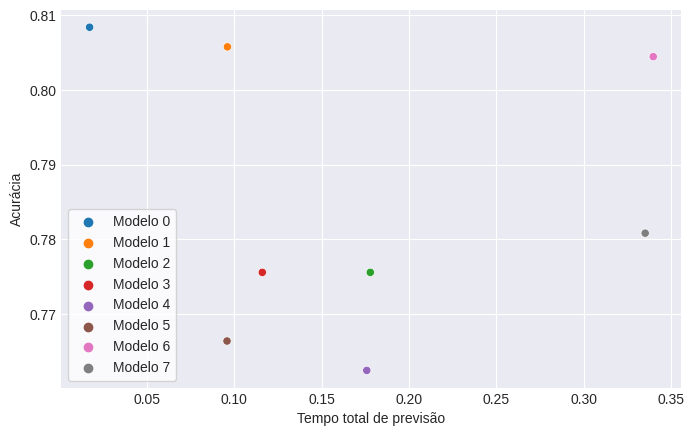

In [65]:
sns.scatterplot(data=troca, x='Tempo total de previsão', y='Acurácia', hue='Modelo')

plt.legend(loc='lower left', frameon=True, facecolor='white');